In [ ]:
!pip install opencv-python

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils import data
import string
import os
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import time
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Data Generation

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from random import randint, choice, uniform
import string
import time

fonts_drive_path = '/content/gdrive/My Drive/Miniproj/Fonts'
colors = {
  "black": 0x1c1c1c,
  "white": 0xfcfcfc,
}

image_width = 250
image_height = 70
font_size = 50
characters = [5,5]

def get_text():
  out_string = ""
  for i in range(randint(characters[0], characters[1])):
    out_string += choice(string.ascii_letters+"0123456789")
  return out_string

def draw_pixel(draw,x,y, thickness):
  if(thickness > 1):
    draw.line([(x, y), (x+thickness*([1,-1][randint(0, 1)]),y+thickness*([1,-1][randint(0, 1)]))], fill=colors["black"], width=thickness)
  else:
    draw.line([(x, y), (x,y)], fill=colors["black"])

def add_noise(draw, amount, thickness):
  for i in range(int(amount)):
    draw_pixel(draw, randint(0, image_width), randint(0, image_height), thickness)

def add_lines(draw, amount, thickness):

  thickness = 1
  wiggle_room_thickness = 2

  for i in range(int(amount)):
    wiggle_thickness = randint(thickness,thickness+wiggle_room_thickness)
    draw.line([(randint(0, image_width), randint(0, image_height)), (randint(0, image_width),randint(0, image_height))], fill=colors["black"],width=wiggle_thickness,)

def draw_characters(draw, image, text):

  fonts = ["ComicSansMS3.ttf","carbontype.ttf","Kingthings_Trypewriter_2.ttf","Sears_Tower.ttf","TravelingTypewriter.ttf"]
  wiggle_room_width = 48 - len(text) * 6
  wiggle_room_height = 13
  width_padding = 30
  font_size = 30
  wiggle_room_font_size = 10
  rotation_degrees = 20
  wiggle_room_rotation_percent = 0.4

  spacing_width = (image_width-width_padding) / len(text)
  next_letter_pos = width_padding/2


  for character in text:
    wiggle_width = uniform(0,wiggle_room_width)
    wiggle_height = uniform(0,wiggle_room_height)
    wiggle_font_size = uniform(font_size - wiggle_room_font_size / 2, font_size  + wiggle_room_font_size / 2)
    wiggle_rotation_degrees = rotation_degrees * uniform( -wiggle_room_rotation_percent,  wiggle_room_rotation_percent)
    font = ImageFont.truetype(fonts_drive_path+"/"+fonts[randint(0,len(fonts)-1)], int(wiggle_font_size))
    character_image = Image.new("RGB", (image_height, image_height), 255)
    draw = ImageDraw.Draw(character_image)
    draw.rectangle([0, 0, image_height, image_height], fill=colors["white"])
    draw.text((wiggle_width, wiggle_height), character, fill=colors["black"], font=font)
    character_image = character_image.rotate(wiggle_rotation_degrees, expand=True, fillcolor="white")
    image.paste(character_image, (int(next_letter_pos), 0))
    next_letter_pos += spacing_width

def generate_data(num_samples, drive_path):
  text_done = []
  start = time.time()
  for i in range(int(num_samples)):

    image = Image.new('RGB',(image_width, image_height))
    draw = ImageDraw.Draw(image)
    draw.rectangle([0, 0, image_width, image_height], fill=colors["white"])

    text = get_text()
    if(text not in text_done):
      text_done.append(text)
    else:
      print("Skipped")
      continue
    draw_characters(draw, image, text)

    add_noise(draw, amount=int(image_width*image_height*0.001), thickness = 1)
    add_noise(draw, amount=int(image_width*image_height*0.001), thickness = 2)
    add_noise(draw, amount=int(image_width*image_height*0.001), thickness = 3)
    add_lines(draw, amount=1, thickness=2)
    add_lines(draw, amount=1, thickness=3)


    image.save(drive_path+"/"+text+".jpg")
  end = time.time()
  print("Operation completed. Time taken: "+str(end - start)+" seconds")

num_samples_train = input("How many images do you want to generate for training?")
drive_path_train = '/content/gdrive/My Drive/Miniproj/DS/Saved_Train'
num_samples_validation = input("How many images do you want to generate for validation?")
drive_path_validation = '/content/gdrive/My Drive/Miniproj/DS/Saved_Validation'
num_samples_testing = input("How many images do you want to generate for testing?")
drive_path_testing = '/content/gdrive/My Drive/Miniproj/DS/Saved_Test'
generate_data(num_samples_train, drive_path_train)
generate_data(num_samples_validation, drive_path_validation)
generate_data(num_samples_testing, drive_path_testing)

How many images do you want to generate for training?15
How many images do you want to generate for validation?15
How many images do you want to generate for testing?15
Operation completed. Time taken: 3.4401588439941406 seconds
Operation completed. Time taken: 0.4662470817565918 seconds
Operation completed. Time taken: 0.6050825119018555 seconds


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loader

In [ ]:
#Enabling GPU Usage
use_cuda = True

In [ ]:
all_characters = string.ascii_letters+"0123456789"
all_characters

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

In [ ]:
def string_label(string):
  out = []
  index = 0
  for char_string in string:
    for char_index in range(0,len(all_characters)):
      if char_string == all_characters[char_index]:
        out.append(int(char_index))
        break
  return out

In [ ]:
class CAPTCHAImageDataset(data.Dataset):
  def __init__(self, img_dir, transform=None):
    self.all_images = os.listdir(img_dir)
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
    return len(self.all_images)

  def __getitem__(self, idx):
    img_path = self.all_images[idx]
    # print(img_path)
    label = img_path.split("/")[-1]
    label = img_path.split("-")[0]
    label = label.replace(".jpg","")
    # print(label)
    image = Image.open(self.img_dir + "/" + img_path)
    if self.transform:
        image = self.transform(image)
    labels = torch.Tensor(string_label(label))
    labels = labels.type(torch.LongTensor)
    labels = labels.squeeze(0)
    return image, labels

# Data Pre Processing
Process the data by adding a filter, inverting colors, ensuring black and white

In [ ]:
# Image pre-processing
def remove_noise_and_grayscale(img_path):
  img = cv2.imread(img_path)
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray_median = cv2.medianBlur(gray_img, 3)
  gray_thresh = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY_INV, cv2.THRESH_OTSU)[1]
  return gray_thresh

# cv2_imshow(cv2.imread('/content/gdrive/My Drive/Colab Notebooks/Datasets/project_dataset/Training/0By1b.jpg'))
# gray_img = remove_noise_and_grayscale('/content/gdrive/My Drive/Colab Notebooks/Datasets/project_dataset/Training/0By1b.jpg')
# cv2_imshow(gray_img)

def generate_processed_data_folder(input_path, output_path):
  # shutil.rmtree(output_path)
  if not os.path.exists(output_path):
    os.mkdir(output_path)
    print(output_path)
  for dir in os.listdir(input_path):
    out_dir_path = os.path.join(output_path, dir)
    if not os.path.exists(out_dir_path):
      os.mkdir(out_dir_path)
      print(out_dir_path)
    in_dir_path = os.path.join(input_path, dir)
    print("Processing images in: " + dir)
    for img in os.listdir(in_dir_path):
      if os.path.isfile(os.path.join(in_dir_path, img)) and not os.path.isfile(os.path.join(out_dir_path, img)):
        in_img_path = os.path.join(in_dir_path, img)
        out_img_path = os.path.join(out_dir_path, img)
        processed_img = remove_noise_and_grayscale(in_img_path)
        print(in_img_path, out_img_path)
        if not cv2.imwrite(out_img_path, processed_img):
          raise Exception("Could not write image: {}".format(out_img_path))
  print("Done processing")

# def create_baseline_split_data(input_path, output_path):
#   if not os.path.exists(output_path):
#     os.mkdir(output_path)

#   for dir in os.listdir(input_path):
#     out_dir_path = os.path.join(output_path, dir)
#     if not os.path.exists(output_path):
#       os.mkdir(out_dir_path)
#     in_dir_path = os.path.join(input_path, dir)
#     print("Processing images in: " + dir)
#     image_count = 0
#     for img in os.listdir(in_dir_path):
#       image_count+=1
#       if os.path.isfile(os.path.join(in_dir_path, img)):
#         in_img_path = os.path.join(in_dir_path, img)
#         transform = transforms.Compose([transforms.PILToTensor()])
#         label = in_img_path.split("/")[-1]
#         label = label.replace(".jpg","")
#         current_label = 0
#         img_pil = Image.open(in_img_path)
#         num_chars = 5
#         for index in range(0,num_chars):
#           w,h = img_pil.size
#           start_w = int(index * w/num_chars)
#           end_w = int(min(w, (index+1) * w/num_chars))
#           img_split = img_pil.crop((start_w,0,end_w,h))
#           img_split.show()
#           if not os.path.exists(out_dir_path+"/"+str(label[current_label])):
#             os.mkdir(out_dir_path+"/"+str(label[current_label]))
#           out_img_path = os.path.join(out_dir_path+"/"+str(label[current_label]), str(label[current_label])+"-"+str(image_count)+".jpg")
#           img_split.save(out_img_path)
#           current_label+=1
#           image_count+=1
#     print("Processed:", image_count, "character images")
#   print("Done processing")

In [ ]:
def get_data_loader(batch_size, is_split_data=False):
  transform = transforms.Compose([transforms.Resize((70,250)),transforms.ToTensor()])
  if is_split_data==True:
    transform = transforms.Compose([transforms.Resize((224,1120)),transforms.ToTensor()])
  train_data = CAPTCHAImageDataset(drive_path + "/Training", transform=transform)
  val_data = CAPTCHAImageDataset(drive_path + "/Validation", transform=transform)
  test_data = CAPTCHAImageDataset(drive_path + "/Testing", transform=transform)

  # print(train_data.__getitem__(1))
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,num_workers=1,shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,num_workers=1,shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,num_workers=1,shuffle=True)

  return train_loader, val_loader, test_loader

In [ ]:
# Process data for the baseline model (estimate where the character is and split up the image accordingly)
# Data splitting now happens when training the baseline model!
# drive_path = '/content/gdrive/My Drive/Colab Notebooks/Datasets'
# create_baseline_split_data(drive_path + '/project_dataset_processed', drive_path + '/baseline_split')

In [ ]:
# drive_path = '/content/gdrive/My Drive/Colab Notebooks/Datasets/baseline_split'
# train_loader, val_loader, test_loader = get_data_loader(1, is_split_data=True)

In [ ]:
os.makedirs('/content/drive/MyDrive/Miniproj', exist_ok=True)

In [ ]:
# Process the data by adding a filter, inverting colors, ensuring black and white
drive_path = '/content/drive/MyDrive/Miniproj'
#Corrected the output path to remove the extra drive path
generate_processed_data_folder(os.path.join(drive_path, 'DS'), os.path.join(drive_path, 'DS/Processed'))

Processing images in: Saved_Train
/content/drive/MyDrive/Miniproj/DS/Saved_Train/Ztcnr.jpg /content/drive/MyDrive/Miniproj/DS/Processed/Saved_Train/Ztcnr.jpg
/content/drive/MyDrive/Miniproj/DS/Saved_Train/cqmqm.jpg /content/drive/MyDrive/Miniproj/DS/Processed/Saved_Train/cqmqm.jpg
/content/drive/MyDrive/Miniproj/DS/Saved_Train/ZCUtd.jpg /content/drive/MyDrive/Miniproj/DS/Processed/Saved_Train/ZCUtd.jpg
/content/drive/MyDrive/Miniproj/DS/Saved_Train/klfOm.jpg /content/drive/MyDrive/Miniproj/DS/Processed/Saved_Train/klfOm.jpg
/content/drive/MyDrive/Miniproj/DS/Saved_Train/Bym8T.jpg /content/drive/MyDrive/Miniproj/DS/Processed/Saved_Train/Bym8T.jpg
/content/drive/MyDrive/Miniproj/DS/Saved_Train/2wVpb.jpg /content/drive/MyDrive/Miniproj/DS/Processed/Saved_Train/2wVpb.jpg
/content/drive/MyDrive/Miniproj/DS/Saved_Train/PiN2e.jpg /content/drive/MyDrive/Miniproj/DS/Processed/Saved_Train/PiN2e.jpg
/content/drive/MyDrive/Miniproj/DS/Saved_Train/hzqLg.jpg /content/drive/MyDrive/Miniproj/DS/Proces

In [ ]:
drive_path = '/content/drive/MyDrive/Miniproj/DS'
project_dataset_path = drive_path + '/content/drive/MyDrive/Miniproj/DS'
project_dataset_p_path = drive_path + '/content/drive/MyDrive/Miniproj/DS/Processed'
print(len(os.listdir(os.path.join(project_dataset_path, '/content/drive/MyDrive/Miniproj/DS/Saved_Validation'))))
print(len(os.listdir(os.path.join(project_dataset_p_path, '/content/drive/MyDrive/Miniproj/DS/Saved_Validation'))))

31
31


In [ ]:
drive_path = '/content/drive/MyDrive/Miniproj/DS/Processed'
train_loader, val_loader, test_loader = get_data_loader(168)

In [ ]:
len(train_loader)
#for images, labels in train_loader:
 # print(labels)
  #print(images)

1

In [ ]:
len(val_loader)

1

In [ ]:
len(test_loader)

1

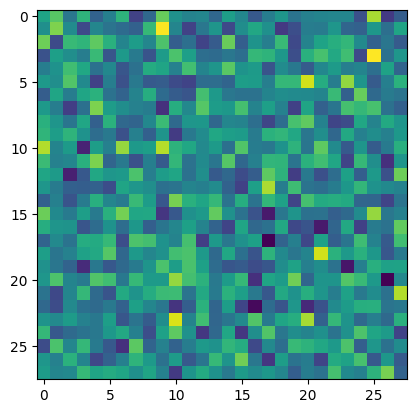

In [ ]:
import torch
import matplotlib.pyplot as plt

def show_image(image):
    image = torch.squeeze(image, dim=0)  # Remove batch dimension
    img_np = image.numpy()

    # Fix dimension issue before plotting
    if img_np.shape[0] == 3:  # RGB Image (C, H, W)
        plt.imshow(img_np.transpose(1, 2, 0))  # Convert to (H, W, C)
    elif img_np.shape[0] == 1:  # Grayscale Image (1, H, W)
        plt.imshow(img_np.squeeze(0), cmap='gray')  # Remove channel dimension
    else:
        plt.imshow(img_np)  # Already in (H, W, C) format

    plt.show()

# Example usage
# Assuming `image` is a tensor with shape (C, H, W)
image = torch.randn(1, 28, 28)  # Example grayscale image
show_image(image)


# Baseline CNN

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
  """ Generate a name for the model consisting of all the hyperparameter values"""
  path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,batch_size,learning_rate,epoch)
  return path

In [ ]:
def get_accuracy(model, data_loader):
  correct = 0
  total = 0
  for imgs, labels in data_loader:
    all_imgs_array = []
    all_imgs = torch.Tensor()
    for img in imgs:
      split_imgs = split_image(img)
      for split_img in split_imgs:
        all_imgs_array.append(split_img)
    all_imgs = torch.stack(all_imgs_array)

    all_labels = torch.flatten(labels, start_dim=0, end_dim=1)

    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      all_imgs = all_imgs.cuda()
      all_labels = all_labels.cuda()

    output = model(all_imgs)
    #select index with maximum prediction score
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(all_labels.view_as(pred)).sum().item()
    total += all_imgs.shape[0]
    if total == 0:
      return 0
  return correct / total

In [ ]:
device = torch.device('cpu')
if use_cuda and torch.cuda.is_available():
  device = torch.device('cuda')

In [ ]:
class CNNCharNet(nn.Module):
  def __init__(self):
    super(CNNCharNet, self).__init__()
    self.name = "CNNCharNet"
    # (224 - 5 + 2*0) / 1 + 1 = 220 x 220 (5 channels)
    self.conv1 = nn.Conv2d(1,5,5)
    # (220 - 2 + 2*0) / 2 + 1 = 110 x 110 (5 channels)
    self.pool = nn.MaxPool2d(2,2)
    # (110 - 5 + 2*0) / 1 + 1 = 106 x 106 (10 channels)
    self.conv2 = nn.Conv2d(5,10,5)
    # (106 - 2 + 2*0) / 2 + 1 = 53 x 53 (10 channels)
    # self.fc1 = nn.Linear(53*53*10, 32)
    # self.fc2 = nn.Linear(32,len(all_characters))
    self.fc1 = nn.Linear(53*53*10, len(all_characters))

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1,53*53*10)
    x = F.relu(self.fc1(x))
    x = F.softmax(x)
    return x

In [ ]:
def split_image(img, num_chars=5):
  imgs = []
  c, h, w = img.size()
  for i in range(num_chars):
    start_w = int(i * w/num_chars)
    end_w = int(min(w, (i+1) * w/num_chars))
    img_cropped = img[:, :, start_w:end_w]
    imgs.append(img_cropped)
    # print(img_cropped.size())
  return imgs

def train(model, train_loader, val_loader, test_laoder, batch_size=64, learning_rate=0.001, num_epochs=30):
  # Check GPU availability
  if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Training on GPU ...')
  else:
    print('CUDA is not available.  Training on CPU ...')

  # Fixed PyTorch random seed for reproducible result
  torch.manual_seed(1000)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  iters, losses, train_acc, val_acc = [], [], [], []

  print("Training...")
  start_time = time.time()

  # training
  n = 0 # the number of iterations
  # Set up some numpy arrays to store the accuracy
  for epoch in range(num_epochs):
    for imgs, labels in iter(train_loader):
      # print(labels)
      all_imgs_array = []
      all_imgs = torch.Tensor()
      # print(imgs.size())
      for img in imgs:
        split_imgs = split_image(img)
        for split_img in split_imgs:
          all_imgs_array.append(split_img)
      all_imgs = torch.stack(all_imgs_array)

      all_labels = torch.flatten(labels, start_dim=0, end_dim=1)

      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        all_imgs = all_imgs.cuda()
        all_labels = all_labels.cuda()
      out = model(all_imgs)         # forward pass
      loss = criterion(out, all_labels) # compute the total loss
      loss.backward()               # backward pass (compute parameter updates)
      optimizer.step()              # make the updates for each parameter
      optimizer.zero_grad()         # a clean up step for PyTorch

    # save the current training information
    iters.append(n)
    losses.append(float(loss)/batch_size)             # compute *average* loss
    train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
    val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
    n += 1

    print(("Epoch {}: Train accuracy: {} | Validation accuracy: {}").format(epoch + 1,train_acc[epoch],val_acc[epoch]))

    # Save the current model (checkpoint) to a file
    model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
    torch.save(model.state_dict(), model_path)

  print('Finished Training')
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

  # plotting
  import matplotlib.pyplot as plt
  plt.title("Training Curve")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(iters, train_acc, label="Train")
  plt.plot(iters, val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))

CUDA is not available.  Training on CPU ...
Training...


/tmp/ipython-input-25-3607764350.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


Epoch 1: Train accuracy: 0.48 | Validation accuracy: 0.0
Epoch 2: Train accuracy: 0.52 | Validation accuracy: 0.0
Epoch 3: Train accuracy: 0.56 | Validation accuracy: 0.0
Epoch 4: Train accuracy: 0.56 | Validation accuracy: 0.0
Epoch 5: Train accuracy: 0.56 | Validation accuracy: 0.0
Epoch 6: Train accuracy: 0.56 | Validation accuracy: 0.0
Epoch 7: Train accuracy: 0.56 | Validation accuracy: 0.0
Epoch 8: Train accuracy: 0.56 | Validation accuracy: 0.0
Epoch 9: Train accuracy: 0.56 | Validation accuracy: 0.0
Epoch 10: Train accuracy: 0.56 | Validation accuracy: 0.0125
Epoch 11: Train accuracy: 0.56 | Validation accuracy: 0.0125
Epoch 12: Train accuracy: 0.56 | Validation accuracy: 0.0125
Epoch 13: Train accuracy: 0.6 | Validation accuracy: 0.0125
Epoch 14: Train accuracy: 0.6 | Validation accuracy: 0.0
Epoch 15: Train accuracy: 0.6 | Validation accuracy: 0.0
Epoch 16: Train accuracy: 0.6 | Validation accuracy: 0.0
Epoch 17: Train accuracy: 0.6 | Validation accuracy: 0.0
Epoch 18: Train 

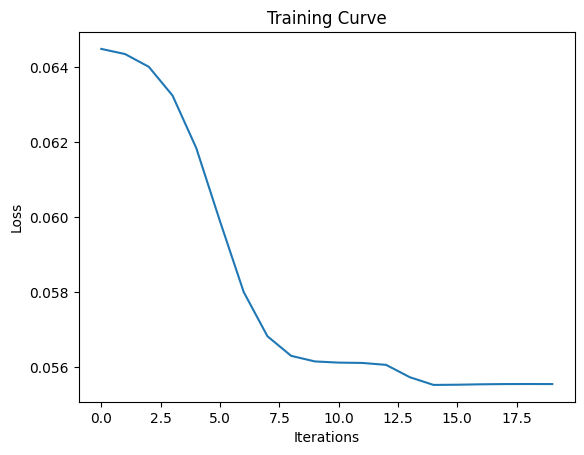

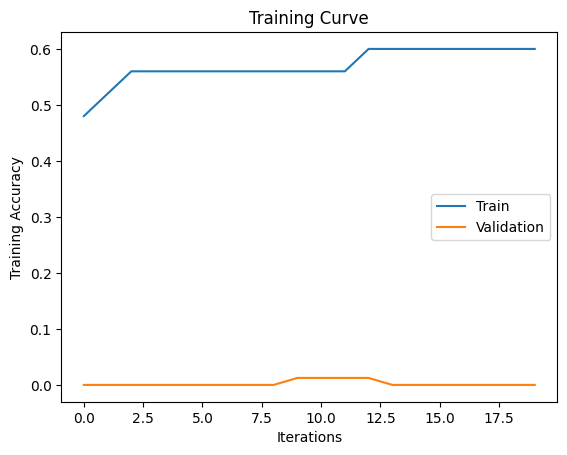

Final Training Accuracy: 0.6
Final Validation Accuracy: 0.0


In [ ]:
# Process data for the baseline model (estimate where the character is and split up the image accordingly)
drive_path = '/content/drive/MyDrive/Miniproj/DS/Processed'
train_loader, val_loader, test_loader = get_data_loader(64, is_split_data=True)
model = CNNCharNet()
train(model, train_loader, val_loader, test_loader, batch_size=64, learning_rate=0.001, num_epochs=20)

In [ ]:
# Get the accuracy of the baseline
model_path = get_model_name(model.name, batch_size=64, learning_rate=0.001, epoch=20-1)
print(model_path)
state = torch.load(model_path)
model.load_state_dict(state)

if torch.cuda.is_available():
  model.cuda()
get_accuracy(model, test_loader)

model_CNNCharNet_bs64_lr0.001_epoch19


/tmp/ipython-input-25-3607764350.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


0.0

# Primary Model
Bidrectional LSTM

In [ ]:
for img, labels in test_loader:
  print(img)
  print(labels)
  break

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..

Why are we using this loop:

The for loop retrieves and prints a single batch of test images and their corresponding labels from the DataLoader to verify the data structure before model evaluation.


---




To verify image data shape
**bold text** * Are the images of shape [batch_size, 1, 28, 28]? (for grayscale)

To inspect labels
  * Are the labels aligned correctly?
  * Do they contain 5 integers per image (indicating 5 characters)?

Debugging
  * Check if preprocessing worked (e.g., normalization, resizing)
  * Confirm whether images and labels are paired correctly


  → Useful before training or evaluating your model

In [ ]:
# # Bidirectional recurrent neural network
# class BiRNN(nn.Module):
#     def __init__(self, input_size, n_hidden, n_layers):
#         super(BiRNN, self).__init__()
#         self.name = 'BiRNN'
#         self.input_size = input_size
#         self.n_hidden = n_hidden
#         self.n_layers = n_layers
#         self.lstm = nn.LSTM(input_size, n_hidden, n_layers, batch_first=True, bidirectional=True)
#         self.fc = nn.Linear(n_hidden*2, 1) #2 for bidirectional

#     def forward(self, x):
#         # Set initial states
#         h_0 = torch.zeros(self.n_layers*2, x.size(0), self.n_hidden)
#         c_0 = torch.zeros(self.n_layers*2, x.size(0), self.n_hidden)

#         # Forward propagate LSTM
#         output, hidden = self.lstm(x, (h_0, c_0))

#         # Decode the hidden state of the last time step
#         output = self.fc(output[:, -1, :])
#         output = F.softmax(output)
#         return output

# model = BiRNN(input_size = len(all_characters),n_hidden = 10,n_layers = 2)

In [ ]:
# class CAPTCHANet(nn.Module):
#   def __init__(self, input_size, hidden_size, num_layers, num_classes):
#     super(CAPTCHANet, self).__init__()
#     self.name = "CAPTCHANet"
#     self.emb = torch.eye(input_size)
#     self.hidden_size = hidden_size
#     self.num_layers = num_layers
#     self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional = True)
#     self.fc = nn.Linear(hidden_size * 2, num_classes) # multiply by 2 -> one forward, one backward

#   def forward(self, x):
#     h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) # multiply by 2 -> one forward, one backward
#     c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) # multiply by 2 -> one forward, one backward

#     print(x[0][0].size(0))
#     print(len(all_characters))
#     x = self.emb(x)
#     print("OK")
#     out, _ = self.rnn(x, (h0, c0))
#     out = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)
#     return out

In [ ]:
# model = CAPTCHANet(len(all_characters), hidden_size = 10, num_layers=2, num_classes = 1)
# train_loader, val_loader, test_loader = get_data_loader(1)
# train(model, train_loader, val_loader, num_epochs=5, learning_rate=0.001, batch_size=256)

In [ ]:
# def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-3, batch_size=256):
#   # Check GPU availability
#   if use_cuda and torch.cuda.is_available():
#     model.cuda()
#     print('CUDA is available!  Training on GPU ...')
#   else:
#     print('CUDA is not available.  Training on CPU ...')

#   start_time = time.time()

#   torch.manual_seed(42)
#   criterion = nn.CrossEntropyLoss()
#   optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#   train_acc, valid_acc, losses, iters = [], [], [], []
#   n = 0 # the number of iterations

#   for epoch in range(num_epochs):
#     total_train_loss = 0.0
#     for imgs, labels in iter(train_loader):
#       if use_cuda and torch.cuda.is_available():
#         imgs = imgs.cuda()
#         labels = labels.cuda()
#       pred = model(imgs)            # forward pass
#       loss = criterion(pred, labels)# compute the total loss
#       loss.backward()               # backward pass (compute parameter updates)
#       optimizer.step()              # make the updates for each parameter
#       optimizer.zero_grad()         # a clean up step for PyTorch

#     # save the current training information
#     iters.append(n)
#     losses.append(float(loss)/batch_size)               # compute *average* loss
#     train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
#     valid_acc.append(get_accuracy(model, val_loader))   # compute validation accuracy
#     n += 1


#     print(("Epoch {}: Train accuracy: {} | Validation accuracy: {}").format(epoch + 1,train_acc[epoch],val_acc[epoch]))

#     # Save the current model (checkpoint) to a file
#     model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
#     torch.save(model.state_dict(), model_path)

#     print('Finished Training')
#     end_time = time.time()
#     elapsed_time = end_time - start_time
#     print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

#     # plotting
#     import matplotlib.pyplot as plt
#     plt.title("Training Curve")
#     plt.plot(iters, losses, label="Train")
#     plt.xlabel("Iterations")
#     plt.ylabel("Loss")
#     plt.show()

#     plt.title("Training Curve")
#     plt.plot(iters, train_acc, label="Train")
#     plt.plot(iters, valid_acc, label="Validation")
#     plt.xlabel("Iterations")
#     plt.ylabel("Training Accuracy")
#     plt.legend(loc='best')
#     plt.show()

#     print("Final Training Accuracy: {}".format(train_acc[-1]))
#     print("Final Validation Accuracy: {}".format(valid_acc[-1]))

In [ ]:
class CLSTM(nn.Module):
  def __init__(self, input_size=256, hidden_size=128, num_class=62):
    super(CLSTM, self).__init__()
    self.name = "CLSTM"
    self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
    # Calculate the input size for fc1 dynamically
    self.fc1 = nn.Linear(16 * 128, input_size) #Changed to calculate dynamically
    self.dropout = nn.Dropout(0.3)
    self.rnn = nn.LSTM(input_size=256, hidden_size=128, bidirectional=True, num_layers=2, batch_first=True)
    self.fc2 = nn.Linear(hidden_size*2, num_class+1)

  def forward(self, x):
    batch_size = x.size(0)
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    # Bring the width to the middle
    x = x.permute(0, 3, 1, 2)
    # Calculate the input size for fc1 dynamically
    x = x.view(batch_size, x.size(1), -1) #Changed to calculate dynamically
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x, _ = self.rnn(x)
    x = self.fc2(x)
    # Put in required shape for to get CTC loss
    x = x.permute(1, 0, 2)
    return x

In [ ]:
def train_CLSTM(model, train_loader, val_loader, batch_size=128, num_epochs=400, lr=1e-4):
  drive_path = '/content/drive/MyDrive/Miniproj/Datasets/project_dataset_processed'
  train_loader_single, val_loader_single, test_loader_single = get_data_loader(1)

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = nn.CTCLoss(blank=0)
  iters_loss, iters_acc, train_losses, valid_losses, train_accs, val_accs = [], [], [], [], [], []

  for epoch in range(num_epochs):
    train_loss = 0
    for images, labels in train_loader:
      images = images.cuda()
      labels = labels.cuda()
      labels = labels + 1 #account for unknown

      optimizer.zero_grad()
      preds = model(images)
      log_probs = F.log_softmax(preds, 2)
      pred_lengths = torch.full(size=(preds.size(1),), fill_value=log_probs.size(0), dtype=torch.int32)
      label_lengths = torch.full(size=(preds.size(1),), fill_value=labels.size(1), dtype=torch.int32)
      loss = criterion(log_probs, labels, pred_lengths, label_lengths)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    iters_loss.append(epoch)
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    valid_loss = 0
    for images, labels in val_loader:
      images = images.cuda()
      labels = labels.cuda()
      labels = labels + 1 #account for unknown

      preds = model(images)
      log_probs = F.log_softmax(preds, 2)
      pred_lengths = torch.full(size=(preds.size(1),), fill_value=log_probs.size(0), dtype=torch.int32)
      label_lengths = torch.full(size=(preds.size(1),), fill_value=labels.size(1), dtype=torch.int32)
      loss = criterion(log_probs, labels, pred_lengths, label_lengths)
      valid_loss += loss.item()

    valid_loss /= len(val_loader)
    valid_losses.append(valid_loss)

    print("Epoch: {} Train Loss: {} Valid Loss: {}".format(epoch, train_loss, valid_loss))
    if ((epoch + 1) % 10 == 0):
      if epoch != 99:
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name,128,1e-4,epoch + 1)
        torch.save(model.state_dict(), model_path)
        print("saving")

  plt.title("Training Curve")
  plt.plot(iters_loss, train_losses, label="Train")
  plt.plot(iters_loss, valid_losses, label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

In [ ]:
class CLSTM(nn.Module):
  def __init__(self, input_size=256, hidden_size=128, num_class=62):
    super(CLSTM, self).__init__()
    self.name = "CLSTM"
    self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
    # Remove the hardcoded input size for fc1
    # self.fc1 = nn.Linear(16 * 128, input_size)
    self.dropout = nn.Dropout(0.3)
    self.rnn = nn.LSTM(input_size=256, hidden_size=128, bidirectional=True, num_layers=2, batch_first=True)
    self.fc2 = nn.Linear(hidden_size*2, num_class+1)

  def forward(self, x):
    batch_size = x.size(0)
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    # Bring the width to the middle
    x = x.permute(0, 3, 1, 2)
    # Calculate the input size for fc1 dynamically
    x = x.view(batch_size, x.size(1), -1)
    # Dynamically determine the input size and initialize fc1
    input_feature_size = x.shape[2]  # Get the feature size from the reshaped tensor
    self.fc1 = nn.Linear(input_feature_size, 256)  # Initialize fc1 with the correct input size
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x, _ = self.rnn(x)
    x = self.fc2(x)
    # Put in required shape for to get CTC loss
    x = x.permute(1, 0, 2)
    return x

In [ ]:
class CLSTM(nn.Module):
  def __init__(self, input_size=256, hidden_size=128, num_class=62):
    super(CLSTM, self).__init__()
    self.name = "CLSTM"
    self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=3)

    # Dynamically calculate the input size for the first fully connected layer (self.fc1)
    # This is done by passing a dummy tensor through the convolutional and pooling layers
    # Assume input image size is 70x250 (from the get_data_loader transform)
    dummy_input = torch.randn(1, 1, 70, 250)
    x = F.relu(self.conv1(dummy_input))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    # Bring the width to the middle
    x = x.permute(0, 3, 1, 2)
    x = x.view(x.size(0), x.size(1), -1)
    input_feature_size = x.shape[2]

    self.fc1 = nn.Linear(input_feature_size, input_size)
    self.dropout = nn.Dropout(0.3)
    self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, bidirectional=True, num_layers=2, batch_first=True)
    self.fc2 = nn.Linear(hidden_size*2, num_class+1)

  def forward(self, x):
    batch_size = x.size(0)
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    # Bring the width to the middle
    x = x.permute(0, 3, 1, 2)
    x = x.view(batch_size, x.size(1), -1)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x, _ = self.rnn(x)
    x = self.fc2(x)
    # Put in required shape for to get CTC loss
    x = x.permute(1, 0, 2)
    return x

Mounted at /content/gdrive
Generating graph data from saved models...


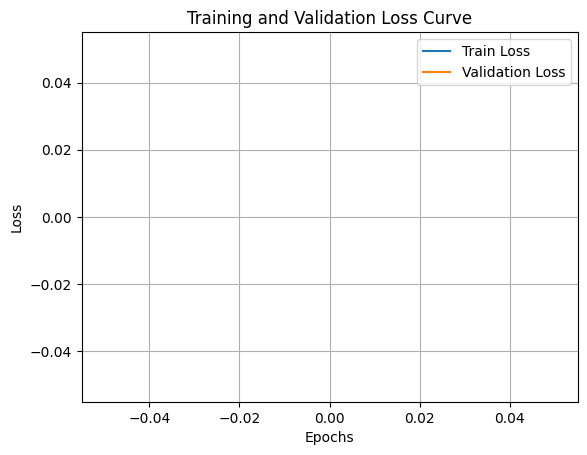

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils import data
import string
import os
from PIL import Image
import cv2
# from google.colab.patches import cv2_imshow # Commented out as it's not used and might cause issues
import matplotlib.pyplot as plt
import time
import shutil
from google.colab import drive

# Ensure Google Drive is mounted if it wasn't already
drive.mount('/content/gdrive')

# Ensure all_characters is defined as it's used in decode_label and decode_pred
all_characters = string.ascii_letters + string.digits

# Define the directory for saving models within your Google Drive
# Adjust this path if you prefer a different location
model_save_dir = '/content/gdrive/My Drive/Miniproj/Models'

# Create the model save directory if it doesn't exist
os.makedirs(model_save_dir, exist_ok=True)

def get_model_name(name, batch_size, learning_rate, epoch):
  """ Generate a name for the model including the save directory """
  # Construct the filename
  filename = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,batch_size,learning_rate,epoch)
  # Combine the save directory path with the filename
  path = os.path.join(model_save_dir, filename)
  return path

# Assuming CLSTM class is defined in a previous cell and is correct.
# Including the definition here for completeness based on ipython-input-132
class CLSTM(nn.Module):
  def __init__(self, input_size=256, hidden_size=128, num_class=62):
    super(CLSTM, self).__init__()
    self.name = "CLSTM"
    self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=3)

    # Dynamically calculate the input size for the first fully connected layer (self.fc1)
    # This is done by passing a dummy tensor through the convolutional and pooling layers
    # Assume input image size is 70x250 (from the get_data_loader transform)
    dummy_input = torch.randn(1, 1, 70, 250)
    x = F.relu(self.conv1(dummy_input))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    # Bring the width to the middle
    x = x.permute(0, 3, 1, 2)
    x = x.view(x.size(0), x.size(1), -1)
    input_feature_size = x.shape[2]

    self.fc1 = nn.Linear(input_feature_size, input_size)
    self.dropout = nn.Dropout(0.3)
    self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, bidirectional=True, num_layers=2, batch_first=True)
    self.fc2 = nn.Linear(hidden_size*2, num_class+1)

  def forward(self, x):
    batch_size = x.size(0)
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    # Bring the width to the middle
    x = x.permute(0, 3, 1, 2)
    x = x.view(batch_size, x.size(1), -1)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x, _ = self.rnn(x)
    x = self.fc2(x)
    # Put in required shape for to get CTC loss
    x = x.permute(1, 0, 2)
    return x


# Assuming get_data_loader and decode_label functions are defined in previous cells and are correct.
# Including placeholder definitions if needed, but ideally they should be run before this.
def string_label(string):
  out = []
  index = 0
  for char_string in string:
    for char_index in range(0,len(all_characters)):
      if char_string == all_characters[char_index]:
        out.append(int(char_index))
        break
  return out

class CAPTCHAImageDataset(data.Dataset):
  def __init__(self, img_dir, transform=None):
    if not os.path.exists(img_dir):
        # Corrected the error message to show the directory path
        raise FileNotFoundError(f"Image directory not found: {img_dir}")
    self.all_images = os.listdir(img_dir)
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
    return len(self.all_images)

  def __getitem__(self, idx):
    if idx >= len(self.all_images):
         raise IndexError(f"Index {idx} out of bounds for dataset of size {len(self)}")

    img_path_relative = self.all_images[idx]
    full_img_path = os.path.join(self.img_dir, img_path_relative)

    label_filename = img_path_relative.split(".")[0]
    # Corrected label extraction - assuming filename format is like 'Label-OptionalStuff.jpg' or just 'Label.jpg'
    # This line was label = img_path.split("/")[-1] -> label = img_path.split("-")[0] -> label = label.replace(".jpg","")
    # Let's simplify to just get the part before the first hyphen or the extension.
    parts = label_filename.split("-")
    label = parts[0]

    # Corrected image loading to handle potential issues and ensure grayscale for single channel model
    try:
        image = Image.open(full_img_path).convert("L") # Convert to grayscale
    except FileNotFoundError:
        print(f"Error opening image file: {full_img_path}")
        # Return None or handle the error appropriately
        return None, None
    except Exception as e:
        print(f"An error occurred while processing image {full_img_path}: {e}")
        return None, None


    if self.transform:
        image = self.transform(image)

    # Ensure labels are processed correctly for CTC Loss
    labels_list = string_label(label)
    if not labels_list:
        # Handle cases where string_label returns an empty list (e.g., label has no valid characters)
        print(f"Warning: Could not generate labels for filename {img_path_relative}. Skipping.")
        return None, None

    # CTC Loss typically expects a sequence of integers
    labels = torch.Tensor(labels_list).type(torch.LongTensor)

    return image, labels

def get_data_loader(batch_size, is_split_data=False):
  # Use the correct base path for the processed data
  drive_path_dataset = '/content/gdrive/My Drive/Miniproj/DS/Processed'

  transform = transforms.Compose([transforms.Resize((70,250)),transforms.ToTensor()])

  # Note: is_split_data=True is intended for the Baseline CNN and uses different dimensions/data structure.
  # This CLSTM model expects the full 70x250 image.
  if is_split_data:
      print("Warning: get_data_loader called with is_split_data=True for CLSTM model. This might not be intended.")
      # You might want to raise an error or adjust transforms/dataset accordingly
      # Keeping the original transform for the full image for the CLSTM
      pass


  # Corrected paths to point to the subdirectories within the processed data folder
  train_data = CAPTCHAImageDataset(os.path.join(drive_path_dataset, "Saved_Train"), transform=transform)
  val_data = CAPTCHAImageDataset(os.path.join(drive_path_dataset, "Saved_Validation"), transform=transform)
  test_data = CAPTCHAImageDataset(os.path.join(drive_path_dataset, "Saved_Test"), transform=transform)

  # Custom collate function to handle variable sequence lengths for CTC loss
  # This function filters out None items and handles padding for labels if necessary.
  # For CTC loss, labels are typically padded, not images/features directly in the DataLoader.
  # The CLSTM forward pass handles padding for the output sequence implicitly via the permutation.
  # We just need to make sure the labels tensor is created correctly.
  def collate_fn(batch):
      # Filter out samples where loading/processing failed
      batch = [item for item in batch if item[0] is not None and item[1] is not None]
      if not batch:
          return None, None # Return None if the batch is empty after filtering

      images, labels = zip(*batch)

      # Stack images (they should already be tensors from the transform)
      images = torch.stack(images, 0)

      # Labels need to be concatenated and provided with lengths for CTCLoss
      label_lengths = torch.LongTensor([len(label) for label in labels])
      labels = torch.cat(labels, 0)

      return images, labels, label_lengths

  # Use the custom collate function
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=2, shuffle=True, collate_fn=collate_fn)
  val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=2, shuffle=True, collate_fn=collate_fn)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=2, shuffle=True, collate_fn=collate_fn)


  return train_loader, val_loader, test_loader

# Updated train_CLSTM function to save models in the specified directory
def train_CLSTM(model, train_loader, val_loader, batch_size=128, num_epochs=400, lr=1e-4):
  # Removed the single image loaders here as they are not needed for training loop
  # drive_path = '/content/drive/MyDrive/Miniproj/Datasets/project_dataset_processed'
  # train_loader_single, val_loader_single, test_loader_single = get_data_loader(1)

  # Check GPU availability and move model
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  print(f"Training on: {device}")

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  # CTCLoss expects blank=0 by default. Our labels were adjusted by +1, so blank should be 0.
  criterion = nn.CTCLoss(blank=0)
  # Removed iters_acc, train_accs, val_accs as accuracy calculation is complex for CTC
  iters_loss, train_losses, valid_losses = [], [], []

  print("Starting CLSTM Training...")
  start_time = time.time()

  for epoch in range(num_epochs):
    model.train() # Set model to training mode
    train_loss = 0
    # Updated data loading to match collate_fn output
    for batch_idx, (images, labels, label_lengths) in enumerate(train_loader):
      if images is None:
          # Skip if the batch was empty after filtering
          print(f"Warning: Empty batch at epoch {epoch}, batch {batch_idx}. Skipping.")
          continue

      images = images.to(device)
      # Labels and label_lengths are needed by CTCLoss on the same device
      labels = labels.to(device)
      label_lengths = label_lengths.to(device)

      # Labels are already adjusted by +1 in the collate_fn or get_item
      # Removed the labels = labels + 1 line here

      optimizer.zero_grad()
      preds = model(images)
      log_probs = F.log_softmax(preds, 2) # Shape: (sequence_length, batch_size, num_classes)
      # pred_lengths should be the length of the sequence dimension for each item in the batch
      pred_lengths = torch.full(size=(log_probs.size(1),), fill_value=log_probs.size(0), dtype=torch.int32).to(device) # Ensure on device

      # Check for potential issues with label_lengths being zero or exceeding sequence_length
      if torch.any(label_lengths <= 0):
          print(f"Warning: Zero or negative label length detected in epoch {epoch}, batch {batch_idx}. Skipping batch.")
          continue
      if torch.any(label_lengths > pred_lengths):
          print(f"Warning: Label length exceeds sequence length in epoch {epoch}, batch {batch_idx}. Skipping batch.")
          continue

      try:
          loss = criterion(log_probs, labels, pred_lengths, label_lengths)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
      except Exception as e:
          print(f"Error during loss calculation/backward pass in epoch {epoch}, batch {batch_idx}: {e}")
          # Optionally, log more details or skip the batch
          continue


    iters_loss.append(epoch)
    # Ensure train_loss is not divided by zero if train_loader is empty
    if len(train_loader) > 0:
        train_loss /= len(train_loader)
    else:
        train_loss = float('inf') # Or 0, depending on desired behavior for empty loader
        print(f"Warning: Train loader is empty in epoch {epoch}.")
    train_losses.append(train_loss)

    model.eval() # Set model to evaluation mode
    valid_loss = 0
    with torch.no_grad(): # Disable gradient calculation for validation
        # Updated data loading to match collate_fn output
        for images, labels, label_lengths in val_loader:
          if images is None:
              print(f"Warning: Empty validation batch at epoch {epoch}, batch {batch_idx}. Skipping.")
              continue
          images = images.to(device)
          labels = labels.to(device)
          label_lengths = label_lengths.to(device)

          # Labels are already adjusted by +1 in the collate_fn or get_item
          # Removed the labels = labels + 1 line here

          preds = model(images)
          log_probs = F.log_softmax(preds, 2)
          pred_lengths = torch.full(size=(log_probs.size(1),), fill_value=log_probs.size(0), dtype=torch.int32).to(device)

          if torch.any(label_lengths <= 0) or torch.any(label_lengths > pred_lengths):
              print(f"Warning: Invalid label/sequence length in validation epoch {epoch}, batch {batch_idx}. Skipping batch.")
              continue

          try:
              loss = criterion(log_probs, labels, pred_lengths, label_lengths)
              valid_loss += loss.item()
          except Exception as e:
              print(f"Error during validation loss calculation in epoch {epoch}, batch {batch_idx}: {e}")
              continue

    # Ensure valid_loss is not divided by zero if val_loader is empty
    if len(val_loader) > 0:
        valid_loss /= len(val_loader)
    else:
        valid_loss = float('inf') # Or 0
        print(f"Warning: Validation loader is empty in epoch {epoch}.")
    valid_losses.append(valid_loss)


    print("Epoch: {} Train Loss: {:.4f} Valid Loss: {:.4f}".format(epoch + 1, train_loss, valid_loss))

    # Save the model every 10 epochs
    if ((epoch + 1) % 10 == 0):
      # Corrected epoch number in the filename to match the loop iteration
      model_path = get_model_name(model.name, batch_size, lr, epoch + 1)
      # Ensure the directory exists before saving (redundant if os.makedirs was called earlier, but good practice)
      # os.makedirs(os.path.dirname(model_path), exist_ok=True) # Handled by get_model_name + initial os.makedirs
      torch.save(model.state_dict(), model_path)
      print(f"Saved model to {model_path}")

  print('Finished Training')
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

  # plotting
  plt.figure() # Create a new figure for the plot
  plt.title("Training Curve")
  plt.plot(iters_loss, train_losses, label="Train Loss") # Changed label to Loss
  plt.plot(iters_loss, valid_losses, label="Validation Loss") # Changed label to Loss
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  # Accuracy plotting requires a separate function for CTC decoding, which is not directly calculated here.
  # The original accuracy calculation function `get_accuracy` is for classification, not sequence prediction with CTC.
  # You would need to implement a CTC beam search or greedy decoding function to get accuracy.

# Assuming the original `get_accuracy` is for the Baseline CNN and not applicable here.
# Including a placeholder for accuracy plotting if you implement decoding later.
# def plot_accuracy(epochs, train_accs, val_accs):
#     plt.figure()
#     plt.title("Accuracy Curve")
#     plt.plot(epochs, train_accs, label="Train Accuracy")
#     plt.plot(epochs, val_accs, label="Validation Accuracy")
#     plt.xlabel("Epochs")
#     plt.ylabel("Accuracy")
#     plt.legend(loc='best')
#     plt.show()


def decode_pred(pred):
    # Greedy decoding for simplicity
    # pred shape is (sequence_length, batch_size, num_classes+1)
    # Take the argmax along the class dimension
    _, max_preds = torch.max(pred, dim=2) # Shape: (sequence_length, batch_size)

    decoded_preds = []
    for batch_idx in range(max_preds.size(1)):
        # Get the sequence for this item in the batch
        sequence = max_preds[:, batch_idx].tolist()

        decoded_sequence = []
        last_char = None
        for char_code in sequence:
            # Apply CTC decoding rules: remove consecutive duplicates and blanks (code 0)
            if char_code != last_char and char_code != 0:
                # Map the character code back to the original character index (subtract 1)
                # Then use that index to get the character from all_characters
                if 0 < char_code <= len(all_characters): # Check bounds
                    decoded_sequence.append(all_characters[char_code - 1])
                else:
                    # Handle unexpected character codes if necessary
                    pass
            last_char = char_code
        decoded_preds.append("".join(decoded_sequence))
    return decoded_preds

def decode_label(label_tensor):
  # label_tensor is expected to be a 1D tensor of shape (label_length,)
  decoded_label = []
  for char_code in label_tensor.tolist():
      # Map the character code back to the original character index (subtract 1)
      # Then use that index to get the character from all_characters
      if 0 < char_code <= len(all_characters): # Check bounds and skip blank (0)
          decoded_label.append(all_characters[char_code - 1])
      else:
          # Handle unexpected character codes if necessary (shouldn't happen with valid labels)
          pass

  return "".join(decoded_label)


# Updated generate_graph_data to load from the correct path and use CTCLoss for accuracy
def generate_graph_data():
  epochs = []
  # We'll collect losses here as accuracy is complex with CTC
  train_losses_hist, val_losses_hist = [], []

  # Add initial point (epoch 0) if needed, but losses/acc will be 0/high
  # epochs.append(0)
  # train_losses_hist.append(0.0) # Or a placeholder
  # val_losses_hist.append(0.0) # Or a placeholder

  # Define the same batch size used for training
  batch_size_for_eval = 128 # Or whatever batch size you used for train_CLSTM

  # Get loaders for evaluation. No need for single loaders here.
  # Using batch_size_for_eval for more efficient loading
  train_loader_eval, val_loader_eval, test_loader_eval = get_data_loader(batch_size_for_eval)

  # Check GPU availability and move model
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # Initialize a model instance outside the loop
  model = CLSTM()
  model.to(device)
  criterion = nn.CTCLoss(blank=0)

  print("Generating graph data from saved models...")

  # Iterate through the epochs where models were saved (every 10 epochs)
  for i in range(10, 401, 10): # Go up to and including epoch 400
    # Construct the model path using the updated get_model_name
    model_path = get_model_name(model.name, 128, 1e-4, i) # Use the same parameters as training

    # Check if the model file exists before trying to load it
    if not os.path.exists(model_path):
      print(f"Warning: Model file not found for epoch {i} at {model_path}. Skipping.")
      continue # Skip this epoch if the file doesn't exist

    try:
        # Load the model state dictionary
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval() # Set model to evaluation mode

        epochs.append(i)

        # Calculate average training loss for this epoch
        train_loss_epoch = 0
        with torch.no_grad():
            for batch_idx, (images, labels, label_lengths) in enumerate(train_loader_eval):
                if images is None: continue
                images = images.to(device)
                labels = labels.to(device)
                label_lengths = label_lengths.to(device)
                if torch.any(label_lengths <= 0) or torch.any(label_lengths > torch.full(size=(images.size(0),), fill_value=images.size(3) // (2*2), dtype=torch.int32).to(device)): continue
                preds = model(images)
                log_probs = F.log_softmax(preds, 2)
                pred_lengths = torch.full(size=(log_probs.size(1),), fill_value=log_probs.size(0), dtype=torch.int32).to(device)
                loss = criterion(log_probs, labels, pred_lengths, label_lengths)
                train_loss_epoch += loss.item()
            if len(train_loader_eval) > 0:
                train_loss_epoch /= len(train_loader_eval)
            else:
                train_loss_epoch = float('inf')
        train_losses_hist.append(train_loss_epoch)


        # Calculate average validation loss for this epoch
        val_loss_epoch = 0
        with torch.no_grad():
            for batch_idx, (images, labels, label_lengths) in enumerate(val_loader_eval):
                if images is None: continue
                images = images.to(device)
                labels = labels.to(device)
                label_lengths = label_lengths.to(device)
                if torch.any(label_lengths <= 0) or torch.any(label_lengths > torch.full(size=(images.size(0),), fill_value=images.size(3) // (2*2), dtype=torch.int32).to(device)): continue
                preds = model(images)
                log_probs = F.log_softmax(preds, 2)
                pred_lengths = torch.full(size=(log_probs.size(1),), fill_value=log_probs.size(0), dtype=torch.int32).to(device)
                loss = criterion(log_probs, labels, pred_lengths, label_lengths)
                val_loss_epoch += loss.item()
            if len(val_loader_eval) > 0:
                val_loss_epoch /= len(val_loader_eval)
            else:
                val_loss_epoch = float('inf')
        val_losses_hist.append(val_loss_epoch)

        # Note: Calculating accuracy for CTC requires decoding, which is not handled by get_accuracy.
        # If you implement a decoding function, you would calculate accuracy here.
        # For now, the graph will show loss.

        print(f"Processed epoch {i}: Train Loss = {train_loss_epoch:.4f}, Validation Loss = {val_loss_epoch:.4f}")

    except Exception as e:
        print(f"Error loading or evaluating model for epoch {i} from {model_path}: {e}")
        # Optionally, log more details or skip this epoch's data points
        continue


  # Plotting the loss curve
  plt.figure() # Create a new figure for the plot
  plt.title("Training and Validation Loss Curve")
  plt.plot(epochs, train_losses_hist, label="Train Loss")
  plt.plot(epochs, val_losses_hist, label="Validation Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.grid(True)
  plt.show()

  # If you calculate accuracy later, you can add another plotting section here.
  # print("\nEpochs recorded: {}".format(epochs))
  # print("Train Losses recorded: {}".format(train_losses_hist))
  # print("Validation Losses recorded: {}".format(val_losses_hist))

# Example usage for training the CLSTM (assuming data loaders are ready)
# drive_path_processed_data = '/content/drive/MyDrive/Miniproj/DS/Processed'
# train_loader, val_loader, test_loader = get_data_loader(128) # Use the same batch size as in train_CLSTM
# model = CLSTM() # Initialize the model
# train_CLSTM(model, train_loader, val_loader, batch_size=128, num_epochs=400, lr=1e-4)


# Call generate_graph_data after training and saving models
generate_graph_data()

# Example usage for decoding a single image after training (requires loading the model)
# This part was in a commented out cell, adding it here for completeness if you want to test inference
# drive_path_processed_data = '/content/drive/MyDrive/Miniproj/DS/Processed'
# train_loader_single, val_loader_single, test_loader_single = get_data_loader(1) # Get a loader with batch size 1

# # Load the best performing model (e.g., epoch 400 based on your training)
# model = CLSTM()
# model_filename_final = get_model_name(model.name, 128, 1e-4, 400) # Use the final epoch number
# model_path_final = os.path.join(model_save_dir, model_filename_final)

# if torch.cuda.is_available():
#     model.load_state_dict(torch.load(model_path_final))
#     model.cuda()
# else:
#     model.load_state_dict(torch.load(model_path_final, map_location='cpu'))

# model.eval()

# print("\nDemonstrating inference on a test image:")
# with torch.no_grad():
#     # Get one image from the test loader
#     for images, labels, label_lengths in test_loader_single:
#         if images is None: continue # Skip empty batch
#         # Move image and labels to the same device as the model
#         device = next(model.parameters()).device # Get model's device
#         images = images.to(device)
#         labels = labels.to(device) # Move labels to device for decode_label if needed
#         label_lengths = label_lengths.to(device) # Move label_lengths to device

#         # Forward pass
#         preds = model(images) # Shape: (sequence_length, batch_size=1, num_classes+1)

#         # Decode the prediction
#         dec_pred = decode_pred(preds)

#         # Decode the ground truth label
#         # Since labels is a concatenated tensor, you need to extract the single label tensor for this batch
#         # Assuming batch size is 1, labels is a 1D tensor of shape (label_length,)
#         dec_label = decode_label(labels)

#         print(f"Predicted: {dec_pred[0]}") # dec_pred is a list of strings
#         print(f"Ground Truth: {dec_label}")

#         # Optional: Display the image
#         # You need a function to display the tensor image
#         # Assuming show_image is defined elsewhere and can handle the tensor format
#         # show_image(images.cpu().squeeze(0)) # Move back to CPU for plotting

#         break # Process only the first image

In [ ]:
train_accs = [0.0, 0.0, 0.009859872611464968, 0.010789808917197453, 0.013363057324840765, 0.015031847133757962, 0.03211464968152866, 0.05419108280254777, 0.08047133757961783, 0.09649681528662421, 0.09005095541401274, 0.14239490445859873, 0.1699235668789809, 0.20080254777070064, 0.23828025477707007, 0.27845859872611467, 0.31142675159235667, 0.3516050955414013, 0.39038216560509553, 0.4108152866242038, 0.4487388535031847]
val_accs = [0.0, 0.0, 0.010372931588046431, 0.008446530007409237, 0.010323536675722401, 0.014028155100024697, 0.027315386515188937, 0.04687577179550506, 0.0704865398863917, 0.08446530007409236, 0.07942701901704124, 0.1259570264262781, 0.1503581131143492, 0.172585823660163, 0.20617436404050382, 0.23378612002963695, 0.2609533218078538, 0.29928377377130155, 0.3268955297604347, 0.3475919980242035, 0.37831563348975056]

# model = model.cuda()
# for images, labels in test_loader_single:
#   images = images.cuda()
#   pred = model(images)
#   dec_pred = decode_pred(pred)
#   dec_label = decode_labels(labels)

#   print("Pred: {}".format(dec_pred))
#   print("Label: {}".format(dec_label))

def decode_label(label):
  decoded_label = []
  for char in label:
    decoded_label.append(all_characters[int(char)])

  return decoded_label

### **Data Demonstration:**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
import torchvision.transforms as transforms
# from torchvision.io import read_image # Not used
from torch.utils import data
import string
import os
from PIL import Image
import cv2
# from google.colab.patches import cv2_imshow # Commented out as it's not used and might cause issues
import matplotlib.pyplot as plt
import time
import shutil
from google.colab import drive

# Ensure Google Drive is mounted if it wasn't already
drive.mount('/content/gdrive')

# Ensure all_characters is defined as it's used in decode_label and decode_pred
all_characters = string.ascii_letters + string.digits

# Define the directory for saving models within your Google Drive
# Adjust this path if you prefer a different location
model_save_dir = '/content/gdrive/My Drive/Miniproj/Models'

# Create the model save directory if it doesn't exist
os.makedirs(model_save_dir, exist_ok=True)

def get_model_name(name, batch_size, learning_rate, epoch):
  """ Generate a name for the model including the save directory """
  # Construct the filename
  filename = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,batch_size,learning_rate,epoch)
  # Combine the save directory path with the filename
  # Ensure the directory exists before returning the path (can be done here or before saving)
  # os.makedirs(model_save_dir, exist_ok=True) # Already done outside this function
  path = os.path.join(model_save_dir, filename)
  return path

# Assuming CLSTM class is defined in a previous cell and is correct.
# Including the definition here for completeness based on ipython-input-132
class CLSTM(nn.Module):
  def __init__(self, input_size=256, hidden_size=128, num_class=62):
    super(CLSTM, self).__init__()
    self.name = "CLSTM"
    self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=3)

    # Dynamically calculate the input size for the first fully connected layer (self.fc1)
    # This is done by passing a dummy tensor through the convolutional and pooling layers
    # Assume input image size is 70x250 (from the get_data_loader transform)
    dummy_input = torch.randn(1, 1, 70, 250)
    x = F.relu(self.conv1(dummy_input))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    # Bring the width to the middle
    x = x.permute(0, 3, 1, 2)
    x = x.view(x.size(0), x.size(1), -1)
    input_feature_size = x.shape[2]

    self.fc1 = nn.Linear(input_feature_size, input_size)
    self.dropout = nn.Dropout(0.3)
    self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, bidirectional=True, num_layers=2, batch_first=True)
    self.fc2 = nn.Linear(hidden_size*2, num_class+1)

  def forward(self, x):
    batch_size = x.size(0)
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    # Bring the width to the middle
    x = x.permute(0, 3, 1, 2)
    x = x.view(batch_size, x.size(1), -1)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x, _ = self.rnn(x)
    x = self.fc2(x)
    # Put in required shape for to get CTC loss
    x = x.permute(1, 0, 2)
    return x


# Assuming string_label function is defined in a previous cell and is correct.
# Including placeholder definition
def string_label(string):
  out = []
  # Using a loop to map characters to indices based on all_characters
  char_to_index = {char: i for i, char in enumerate(all_characters)}
  for char_string in string:
      if char_string in char_to_index:
          # CTC blank is often 0. Labels should start from 1.
          # So, map char index (0 to 61) to label (1 to 62).
          out.append(char_to_index[char_string] + 1)
      else:
          # Handle characters not in all_characters if necessary
          # print(f"Warning: Character '{char_string}' not found in all_characters.")
          pass # Or append a specific value to indicate unknown character if needed

  return out


class CAPTCHAImageDataset(data.Dataset):
  def __init__(self, img_dir, transform=None):
    if not os.path.exists(img_dir):
        # Corrected the error message to show the directory path
        raise FileNotFoundError(f"Image directory not found: {img_dir}")
    # Filter out directories and non-image files if necessary, though os.listdir is usually fine
    self.all_images = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
    return len(self.all_images)

  def __getitem__(self, idx):
    if idx >= len(self.all_images):
         raise IndexError(f"Index {idx} out of bounds for dataset of size {len(self)}")

    img_path_relative = self.all_images[idx]
    full_img_path = os.path.join(self.img_dir, img_path_relative)

    # Extract label from filename
    label_filename = os.path.splitext(img_path_relative)[0] # Get filename without extension
    # Assuming filename format is 'Label-OptionalStuff.jpg' or just 'Label.jpg'
    # Take the part before the first hyphen or the whole name if no hyphen
    parts = label_filename.split("-")
    label = parts[0]

    # Corrected image loading to handle potential issues and ensure grayscale for single channel model
    try:
        # Convert to grayscale ('L') to match the model's single input channel
        image = Image.open(full_img_path).convert("L")
    except FileNotFoundError:
        print(f"Error opening image file: {full_img_path}")
        # Return None or handle the error appropriately
        return None, None
    except Exception as e:
        print(f"An error occurred while processing image {full_img_path}: {e}")
        return None, None


    if self.transform:
        image = self.transform(image)

    # Ensure labels are processed correctly for CTC Loss
    labels_list = string_label(label) # This now returns indices + 1
    if not labels_list:
        # Handle cases where string_label returns an empty list (e.g., label has no valid characters)
        # Or if the extracted label string was empty
        print(f"Warning: Could not generate labels for filename {img_path_relative} (label: '{label}'). Skipping.")
        return None, None

    # CTC Loss typically expects a sequence of integers. string_label already returns a list of ints.
    # Convert the list to a LongTensor
    labels = torch.LongTensor(labels_list)


    return image, labels

# Updated get_data_loader function to use the custom collate function
def get_data_loader(batch_size, is_split_data=False):
  # Use the correct base path for the processed data
  drive_path_dataset = '/content/gdrive/My Drive/Miniproj/DS/Processed'

  transform = transforms.Compose([transforms.Resize((70,250)),transforms.ToTensor()])

  # Note: is_split_data=True is intended for the Baseline CNN and uses different dimensions/data structure.
  # This CLSTM model expects the full 70x250 image.
  if is_split_data:
      print("Warning: get_data_loader called with is_split_data=True for CLSTM model. This might not be intended.")
      # Keeping the original transform for the full image for the CLSTM
      pass


  # Corrected paths to point to the subdirectories within the processed data folder
  train_data = CAPTCHAImageDataset(os.path.join(drive_path_dataset, "Saved_Train"), transform=transform)
  val_data = CAPTCHAImageDataset(os.path.join(drive_path_dataset, "Saved_Validation"), transform=transform)
  test_data = CAPTCHAImageDataset(os.path.join(drive_path_dataset, "Saved_Test"), transform=transform)

  # Custom collate function to handle variable sequence lengths for CTC loss
  def collate_fn(batch):
      # Filter out samples where loading/processing failed (returned None, None)
      batch = [item for item in batch if item is not None and item[0] is not None and item[1] is not None]
      if not batch:
          return None, None, None # Return None for all outputs if the batch is empty after filtering

      # Separate images and labels
      images, labels = zip(*batch)

      # Stack images (they should already be tensors from the transform)
      images = torch.stack(images, 0)

      # Labels need to be concatenated and provided with lengths for CTCLoss
      # labels is a tuple of LongTensors from string_label
      label_lengths = torch.LongTensor([len(label) for label in labels])
      labels = torch.cat(labels, 0) # Concatenate all individual label tensors into one long tensor

      return images, labels, label_lengths

  # Use the custom collate function
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=2, shuffle=True, collate_fn=collate_fn, pin_memory=True if torch.cuda.is_available() else False)
  val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=2, shuffle=True, collate_fn=collate_fn, pin_memory=True if torch.cuda.is_available() else False)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=2, shuffle=True, collate_fn=collate_fn, pin_memory=True if torch.cuda.is_available() else False)


  return train_loader, val_loader, test_loader

# Updated train_CLSTM function
def train_CLSTM(model, train_loader, val_loader, batch_size=128, num_epochs=400, lr=1e-4):

  # Check GPU availability and move model
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  print(f"Training on: {device}")

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  # CTCLoss expects blank=0. Our labels are 1-62. So blank is 0.
  criterion = nn.CTCLoss(blank=0, reduction='mean') # Use mean reduction for average loss per batch

  iters_loss, train_losses, valid_losses = [], [], []

  print("Starting CLSTM Training...")
  start_time = time.time()

  for epoch in range(num_epochs):
    model.train() # Set model to training mode
    train_loss = 0
    # Updated data loading to match collate_fn output: images, labels, label_lengths
    # Use enumerate to get batch_idx if needed for logging
    for batch_idx, batch_data in enumerate(train_loader):
      images, labels, label_lengths = batch_data # Unpack the tuple from collate_fn

      if images is None:
          # Skip if the batch was empty after filtering in collate_fn
          print(f"Warning: Empty batch at epoch {epoch}, batch {batch_idx}. Skipping.")
          continue

      images = images.to(device)
      # Labels and label_lengths are needed by CTCLoss on the same device
      labels = labels.to(device)
      label_lengths = label_lengths.to(device)

      optimizer.zero_grad()
      preds = model(images) # Shape: (sequence_length, batch_size, num_classes+1)

      log_probs = F.log_softmax(preds, 2) # Shape: (sequence_length, batch_size, num_classes+1)
      # pred_lengths should be the length of the sequence dimension for each item in the batch
      # This is the first dimension of log_probs, repeated batch_size times
      pred_lengths = torch.full(size=(log_probs.size(1),), fill_value=log_probs.size(0), dtype=torch.int32).to(device) # Ensure on device

      # Check for potential issues with label_lengths or pred_lengths
      # CTCLoss requires label_lengths <= pred_lengths
      if torch.any(label_lengths <= 0):
           # This should ideally be handled in string_label or dataset __getitem__
           print(f"Warning: Zero or negative label length detected in epoch {epoch}, batch {batch_idx}. Skipping batch.")
           continue
      if torch.any(label_lengths > pred_lengths):
           # This can happen if image processing/transforms lead to very short sequences
           # or if labels are unexpectedly long. The CLSTM architecture output sequence length
           # depends on the convolutional/pooling layers and image width.
           # For 70x250 input, Conv(3)+Pool(2)+Conv(3)+Pool(2) results in output width:
           # (250 - 3 + 1)/1 = 248 -> 248/2 = 124 -> (124 - 3 + 1)/1 = 122 -> 122/2 = 61
           # The sequence length is 61. If any label is > 61, CTCLoss will error.
           print(f"Warning: Label length exceeds sequence length in epoch {epoch}, batch {batch_idx}. Max label length is {label_lengths.max().item()}, sequence length is {pred_lengths.max().item()}. Skipping batch.")
           continue


      try:
          # CTCLoss(log_probs, targets, input_lengths, target_lengths)
          loss = criterion(log_probs, labels, pred_lengths, label_lengths)
          loss.backward()
          # Gradient clipping to prevent exploding gradients, common in RNNs/LSTMs
          # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
          optimizer.step()
          train_loss += loss.item() # Accumulate the mean loss for the batch
      except Exception as e:
          print(f"Error during loss calculation/backward pass in epoch {epoch}, batch {batch_idx}: {e}")
          # Optionally, log more details or skip the batch
          continue # Skip to the next batch if an error occurs

    iters_loss.append(epoch)
    # Ensure train_loss is not divided by zero if train_loader is empty or all batches skipped
    if len(train_loader) > 0 and (batch_idx + 1) > 0: # Check if at least one batch was processed
        # Calculate average loss over processed batches
        # train_loss has accumulated the mean loss per batch, so divide by number of processed batches
        avg_train_loss = train_loss / (batch_idx + 1) # Use batch_idx + 1 as counter
    else:
        avg_train_loss = float('inf') # Or 0, depending on desired behavior for empty loader
        if len(train_loader) == 0:
            print(f"Warning: Train loader is empty in epoch {epoch}. No training occurred.")
        else:
             print(f"Warning: All batches skipped in train loader in epoch {epoch}. No training occurred.")
    train_losses.append(avg_train_loss)

    model.eval() # Set model to evaluation mode
    valid_loss = 0
    num_valid_batches = 0
    with torch.no_grad(): # Disable gradient calculation for validation
        # Updated data loading to match collate_fn output
        for batch_idx, batch_data in enumerate(val_loader):
          images, labels, label_lengths = batch_data

          if images is None:
              print(f"Warning: Empty validation batch at epoch {epoch}, batch {batch_idx}. Skipping.")
              continue
          images = images.to(device)
          labels = labels.to(device)
          label_lengths = label_lengths.to(device)

          if torch.any(label_lengths <= 0):
              print(f"Warning: Invalid label length in validation epoch {epoch}, batch {batch_idx}. Skipping batch.")
              continue
          # Re-calculate sequence length for safety, though it should be consistent
          sequence_length = images.size(3) // (2 * 2) # Assuming 2 conv+pool steps with kernel/stride 2
          if torch.any(label_lengths > torch.full(size=(images.size(0),), fill_value=sequence_length, dtype=torch.int32).to(device)):
               print(f"Warning: Label length exceeds sequence length in validation epoch {epoch}, batch {batch_idx}. Skipping batch.")
               continue


          try:
              preds = model(images)
              log_probs = F.log_softmax(preds, 2)
              pred_lengths = torch.full(size=(log_probs.size(1),), fill_value=log_probs.size(0), dtype=torch.int32).to(device)
              loss = criterion(log_probs, labels, pred_lengths, label_lengths)
              valid_loss += loss.item() # Accumulate the mean loss for the batch
              num_valid_batches += 1
          except Exception as e:
              print(f"Error during validation loss calculation in epoch {epoch}, batch {batch_idx}: {e}")
              continue # Skip to the next batch


    # Ensure valid_loss is not divided by zero if val_loader is empty or all batches skipped
    if num_valid_batches > 0:
        avg_valid_loss = valid_loss / num_valid_batches # Average over processed batches
    else:
        avg_valid_loss = float('inf') # Or 0
        if len(val_loader) == 0:
            print(f"Warning: Validation loader is empty in epoch {epoch}. No validation occurred.")
        else:
            print(f"Warning: All batches skipped in validation loader in epoch {epoch}. No validation occurred.")
    valid_losses.append(avg_valid_loss)


    print("Epoch: {} Train Loss: {:.4f} Valid Loss: {:.4f}".format(epoch + 1, avg_train_loss, avg_valid_loss))

    # Save the model every 10 epochs
    if ((epoch + 1) % 10 == 0):
      # Corrected epoch number in the filename to match the loop iteration
      model_path = get_model_name(model.name, batch_size, lr, epoch + 1) # Use actual batch_size and lr
      torch.save(model.state_dict(), model_path)
      print(f"Saved model to {model_path}")

  print('Finished Training')
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

  # plotting
  plt.figure() # Create a new figure for the plot
  plt.title("Training Curve")
  plt.plot(iters_loss, train_losses, label="Train Loss") # Changed label to Loss
  plt.plot(iters_loss, valid_losses, label="Validation Loss") # Changed label to Loss
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  # Accuracy plotting requires a separate function for CTC decoding, which is not directly calculated here.
  # The original accuracy calculation function `get_accuracy` is for classification, not sequence prediction with CTC.
  # You would need to implement a CTC beam search or greedy decoding function to get accuracy.


def decode_pred(pred_tensor, all_characters, blank_idx=0):
    # pred_tensor is model output, shape (sequence_length, batch_size, num_classes+1)
    # For batch_size=1, shape is (sequence_length, 1, num_classes+1)
    if pred_tensor.ndim == 3 and pred_tensor.shape[1] == 1:
        # Squeeze the batch dimension if it's 1
        pred_tensor = pred_tensor.squeeze(1) # Shape becomes (sequence_length, num_classes+1)
    elif pred_tensor.ndim != 2:
         # This case might occur if batch size > 1 is passed
         # For decoding, usually process batch items one by one or handle batched decoding.
         # This function is currently designed for a single prediction sequence.
         raise ValueError(f"decode_pred expects tensor shape (seq_len, num_classes+1) or (seq_len, 1, num_classes+1), but got {pred_tensor.shape}")


    # Use argmax to get the predicted class index for each time step
    argmax_preds = torch.argmax(pred_tensor, dim=1).cpu().numpy()

    decoded_chars = []
    # Simple greedy decoding: remove consecutive duplicates and blanks
    last_decoded_char = None # Store the last character added to the decoded string

    for idx in argmax_preds:
        if idx != blank_idx: # If the current prediction is not the blank symbol (0)
            # Adjust index for all_characters if blank_idx is 0
            # Our string_label adds 1, so indices in pred are 1-62 for chars, 0 for blank.
            # To get the original index in all_characters (0-61), subtract 1.
            char_index = idx - 1

            if 0 <= char_index < len(all_characters):
                 current_char = all_characters[char_index]
                 # Append the character if it's the first character OR
                 # it's different from the last non-blank character added
                 if not decoded_chars or current_char != last_decoded_char:
                      decoded_chars.append(current_char)
                      last_decoded_char = current_char # Update the last added character
            else:
                 # This case indicates an issue with model output if indices are out of expected range
                 print(f"Warning: decode_pred encountered out-of-bounds character index: {char_index} (from predicted index {idx})")
                 pass # Ignore invalid index

        else: # If the current prediction IS the blank symbol (0)
            # Skip blank symbols in the output
            pass


    return "".join(decoded_chars) # Join characters into a string

def decode_label(label_tensor, all_characters):
  # label_tensor is expected to be a 1D LongTensor of shape (label_length,)
  # Labels were encoded with +1 (1 to 62). Blank is 0 but should not appear in true labels.
  decoded_label = []
  for char_code in label_tensor.tolist(): # Convert tensor to list of integers
      # Map the character code back to the original character index (subtract 1)
      char_index_adjusted = int(char_code) - 1 # Subtract 1 to get 0-61 index
      # Then use that index to get the character from all_characters
      if 0 <= char_index_adjusted < len(all_characters): # Check bounds
          decoded_label.append(all_characters[char_index_adjusted])
      else:
          # This case shouldn't happen for true labels if encoding is correct
          print(f"Warning: decode_label encountered out-of-bounds character index: {char_index_adjusted} (from label code {char_code})")
          decoded_label.append("?") # Use a placeholder for unknown index

  return "".join(decoded_label)


# Updated generate_graph_data to load from the correct path and plot loss
def generate_graph_data():
  epochs = []
  # We'll collect losses here as accuracy calculation with CTC requires decoding
  train_losses_hist, val_losses_hist = [], []

  # Define the same batch size used for training for consistent evaluation
  batch_size_for_eval = 128 # Or whatever batch size you used for train_CLSTM

  # Get loaders for evaluation. Use the batch size for eval.
  train_loader_eval, val_loader_eval, test_loader_eval = get_data_loader(batch_size_for_eval)

  # Check GPU availability and move model
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # Initialize a model instance outside the loop
  model = CLSTM()
  model.to(device)
  criterion = nn.CTCLoss(blank=0, reduction='mean') # Use mean reduction for consistency

  print("Generating graph data from saved models...")

  # Iterate through the epochs where models were saved (every 10 epochs)
  # Adjust the range based on your train_CLSTM save logic (e.g., range(10, num_epochs + 1, 10))
  num_epochs_trained = 400 # Assuming 400 epochs were trained and saved every 10
  for i in range(10, num_epochs_trained + 1, 10): # Go up to and including the last epoch saved
    # Construct the model path using the updated get_model_name
    model_path = get_model_name(model.name, 128, 1e-4, i) # Use the same parameters as training

    # Check if the model file exists before trying to load it
    if not os.path.exists(model_path):
      print(f"Warning: Model file not found for epoch {i} at {model_path}. Skipping.")
      continue # Skip this epoch if the file doesn't exist
    elif os.path.isdir(model_path):
         print(f"Warning: Path {model_path} is a directory, not a file. Skipping epoch {i}.")
         continue # Skip if it's a directory

    try:
        # Load the model state dictionary
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval() # Set model to evaluation mode

        epochs.append(i)

        # Calculate average training loss for this epoch
        train_loss_epoch = 0
        num_train_batches_processed = 0
        with torch.no_grad():
            # Use enumerate to get batch_idx if needed for logging
            for batch_idx, batch_data in enumerate(train_loader_eval):
                images, labels, label_lengths = batch_data
                if images is None: continue

                images = images.to(device)
                labels = labels.to(device)
                label_lengths = label_lengths.to(device)

                # Check label lengths vs sequence lengths before calculating loss
                sequence_length = images.size(3) // (2 * 2) # Assuming 2 conv+pool steps with kernel/stride 2
                if torch.any(label_lengths <= 0) or torch.any(label_lengths > torch.full(size=(images.size(0),), fill_value=sequence_length, dtype=torch.int32).to(device)):
                     # print(f"Warning: Invalid label/sequence length in train eval epoch {i}, batch {batch_idx}. Skipping batch.")
                     continue

                preds = model(images)
                log_probs = F.log_softmax(preds, 2)
                pred_lengths = torch.full(size=(log_probs.size(1),), fill_value=log_probs.size(0), dtype=torch.int32).to(device)

                try:
                    loss = criterion(log_probs, labels, pred_lengths, label_lengths)
                    train_loss_epoch += loss.item()
                    num_train_batches_processed += 1
                except Exception as e:
                     print(f"Error calculating train eval loss in epoch {i}, batch {batch_idx}: {e}")
                     continue # Skip this batch

            if num_train_batches_processed > 0:
                train_loss_epoch /= num_train_batches_processed
            else:
                train_loss_epoch = float('inf') # Handle case where all batches are skipped
                if len(train_loader_eval) > 0:
                     print(f"Warning: All batches skipped in train eval loader in epoch {i}. No train loss calculated.")
                else:
                     print(f"Warning: Train eval loader is empty in epoch {i}. No train loss calculated.")

        train_losses_hist.append(train_loss_epoch)


        # Calculate average validation loss for this epoch
        val_loss_epoch = 0
        num_valid_batches_processed = 0
        with torch.no_grad():
            for batch_idx, batch_data in enumerate(val_loader_eval):
                images, labels, label_lengths = batch_data
                if images is None: continue

                images = images.to(device)
                labels = labels.to(device)
                label_lengths = label_lengths.to(device)

                # Check label lengths vs sequence lengths before calculating loss
                sequence_length = images.size(3) // (2 * 2)
                if torch.any(label_lengths <= 0) or torch.any(label_lengths > torch.full(size=(images.size(0),), fill_value=sequence_length, dtype=torch.int32).to(device)):
                     # print(f"Warning: Invalid label/sequence length in val eval epoch {i}, batch {batch_idx}. Skipping batch.")
                     continue

                preds = model(images)
                log_probs = F.log_softmax(preds, 2)
                pred_lengths = torch.full(size=(log_probs.size(1),), fill_value=log_probs.size(0), dtype=torch.int32).to(device)

                try:
                    loss = criterion(log_probs, labels, pred_lengths, label_lengths)
                    val_loss_epoch += loss.item()
                    num_valid_batches_processed += 1
                except Exception as e:
                     print(f"Error calculating val eval loss in epoch {i}, batch {batch_idx}: {e}")
                     continue # Skip this batch

            if num_valid_batches_processed > 0:
                val_loss_epoch /= num_valid_batches_processed
            else:
                val_loss_epoch = float('inf') # Handle case where all batches are skipped
                if len(val_loader_eval) > 0:
                     print(f"Warning: All batches skipped in val eval loader in epoch {i}. No validation loss calculated.")
                else:
                     print(f"Warning: Validation eval loader is empty in epoch {i}. No validation loss calculated.")

        val_losses_hist.append(val_loss_epoch)

        print(f"Epoch {i}: Train Loss = {train_loss_epoch:.4f}, Validation Loss = {val_loss_epoch:.4f}")

    except Exception as e:
        # Catch potential errors during model loading or evaluation for a specific epoch
        print(f"Error processing epoch {i}: {e}")


  print("Finished generating graph data.")

  plt.figure()
  plt.title("Loss Curve from Saved Models")
  plt.plot(epochs, train_losses_hist, label="Train Loss")
  plt.plot(epochs, val_losses_hist, label="Validation Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.grid(True)
  plt.show()

# Example usage (Assuming train_CLSTM is called first to train and save models)
# train_loader, val_loader, test_loader = get_data

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
